# **v4.0 GraphSAGE Architecture with MLP**

nodes: nodecount2km SUM

edges: integration2km

ADDITIONS:
+ sigmoid activation
+ normalize values

#TODO 
Development - preventing data leakage in train/test split
 A: split same graph to prevent node overlap
 B: train on city A, test on city B (will require cities of similar sizes)

In [3]:
import os

#giving the directory of the files
path = "C:/Users/chalm/Documents/Sem 2/Computational Intelligence/datasets/" # Corrected path to the directory
# using chdir for changing the directory to the path we look for
os.chdir(path)

**1. Loading dataset**

Converting road network to:
 - Nodes: Start/End coords of LINESTRING geometry
 - Edges: LINESTRING geometry

In [4]:

import pandas as pd
import re

# Load dataset
df = pd.read_csv("Birmingham_ALL.csv")  # adjust path as needed

# Function to extract coordinate pairs from WKT LINESTRING
def extract_coords(linestring):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", linestring)
    coords = list(map(float, coords))
    return (coords[0], coords[1]), (coords[2], coords[3])  # (x1, y1), (x2, y2)

# Apply extraction to geometry column
df['source_coords'], df['target_coords'] = zip(*df['geometry'].apply(extract_coords))

# Preview the new columns
df[['geometry', 'source_coords', 'target_coords']].head()


,geometry,source_coords,target_coords
0,"LINESTRING (399984 281923, 399953 281943)","(399984.0, 281923.0)","(399953.0, 281943.0)"
1,"LINESTRING (399953 281943, 399990 281940)","(399953.0, 281943.0)","(399990.0, 281940.0)"
2,"LINESTRING (399870 277371, 399848 277354)","(399870.0, 277371.0)","(399848.0, 277354.0)"
3,"LINESTRING (400343 277539, 400796 277452)","(400343.0, 277539.0)","(400796.0, 277452.0)"
4,"LINESTRING (400173 277544, 400271 277545)","(400173.0, 277544.0)","(400271.0, 277545.0)"


In [5]:
# Step 1: Get all unique coordinates
all_coords = pd.concat([df['source_coords'], df['target_coords']])
unique_coords = pd.Series(all_coords.unique())

# Step 2: Create a mapping from coordinate → node ID
coord_to_id = {coord: idx for idx, coord in enumerate(unique_coords)}

# Step 3: Map source/target coords to node IDs
df['source_id'] = df['source_coords'].map(coord_to_id)
df['target_id'] = df['target_coords'].map(coord_to_id)

# Step 4: Build the edge list
edge_index = df[['source_id', 'target_id']].values.T  # shape [2, num_edges]

# Optional: Confirm number of unique nodes and edges
num_nodes = len(unique_coords)
num_edges = edge_index.shape[1]

print(f"Graph has {num_nodes} nodes and {num_edges} edges")


Graph has 12509 nodes and 16192 edges


**2. Correlation Matrix**

To determine appropriate node features for training

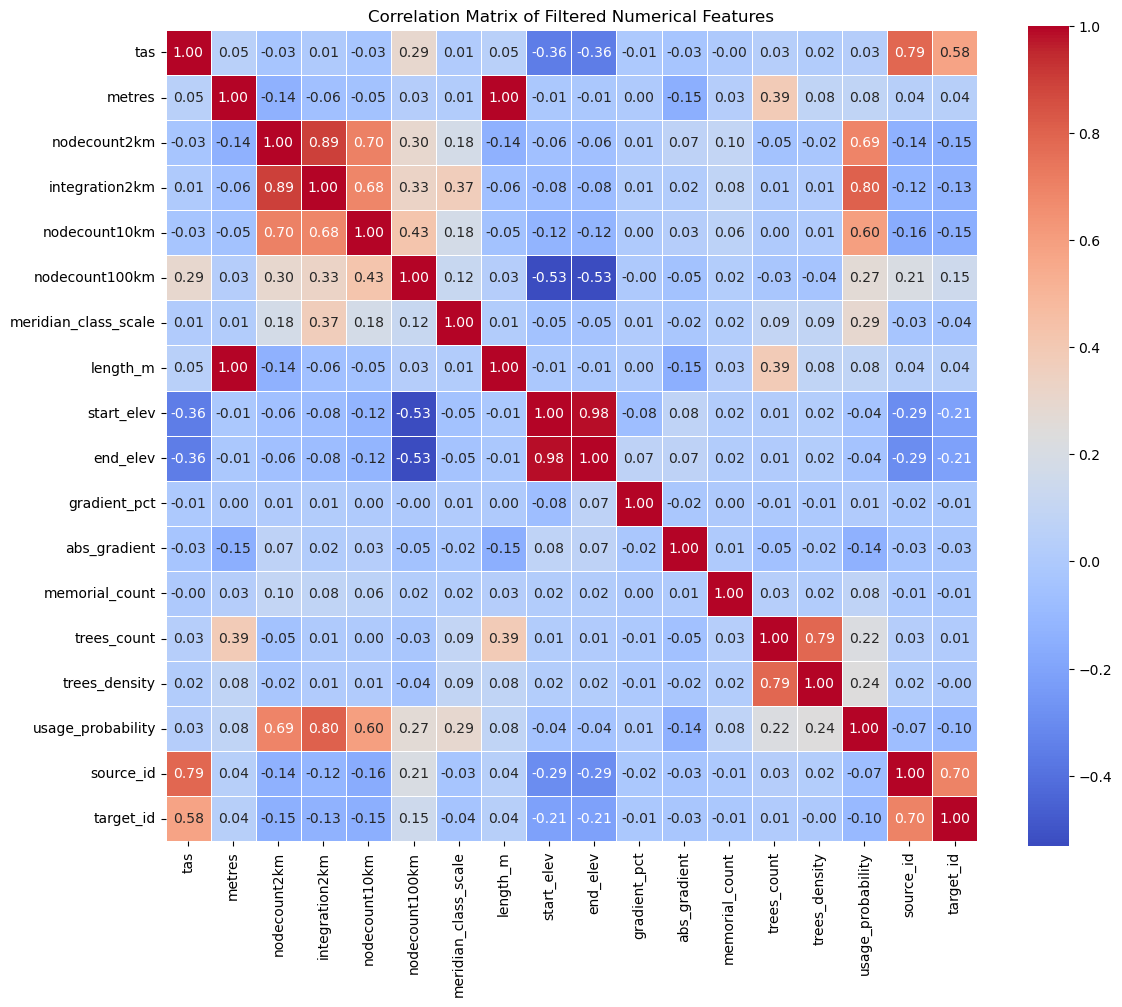

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the columns that are disallowed (choice*, integration100km, etc.)
excluded_keywords = ['choice', 'integration100km', 'integration10km', 'rank']
columns_to_include = [col for col in df.columns if not any(key in col.lower() for key in excluded_keywords)]

# Filter dataframe
filtered_df = df[columns_to_include]

# Select only numerical columns
numerical_df = filtered_df.select_dtypes(include='number')

# Compute full correlation matrix
correlation_matrix = numerical_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix of Filtered Numerical Features')
plt.tight_layout()
plt.show()

In [8]:
correlation_matrix['usage_probability'].sort_values(ascending=False)

usage_probability       1.000000
integration2km          0.804965
nodecount2km            0.691739
nodecount10km           0.597459
meridian_class_scale    0.293920
nodecount100km          0.265983
trees_density           0.237661
trees_count             0.219305
length_m                0.081323
metres                  0.081323
memorial_count          0.075163
tas                     0.025824
gradient_pct            0.009773
end_elev               -0.042650
start_elev             -0.044579
source_id              -0.070514
target_id              -0.098821
abs_gradient           -0.138376
Name: usage_probability, dtype: float64

Selected training features are:
- [high correation]             `integration 2km`
- [usage_probability parameter] `nodecount2km`
- [usage_probability parameter] `meridian_class_scale` (road width)
- [usage_probability parameter] `trees_density`
- [usage_probability parameter] `memorial_count`

In [58]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler

# List of edge features to aggregate into nodes
edge_features = ['integration2km', 'nodecount2km', 'meridian_class_scale', 'trees_density', 'memorial_count']

# Initialize a dictionary to hold node-level aggregations
node_feature_dict = {feat: np.zeros(num_nodes) for feat in edge_features}

# Aggregate: sum edge features to connected nodes (both source and target)
for _, row in df.iterrows():
    src = row['source_id']
    tgt = row['target_id']
    for feat in edge_features:
        val = row[feat]
        node_feature_dict[feat][src] += val
        node_feature_dict[feat][tgt] += val

# Stack all features into a single tensor: shape [num_nodes, num_features]
node_feature_matrix = np.stack([node_feature_dict[feat] for feat in edge_features], axis=1)
x = torch.tensor(node_feature_matrix, dtype=torch.float)

scaler = StandardScaler()
x_np = scaler.fit_transform(x.numpy())
x = torch.tensor(x_np, dtype=torch.float)


print("Node feature tensor shape:", x.shape)  # Should be [num_nodes, 5]


Node feature tensor shape: torch.Size([12509, 5])


In [59]:
from torch_geometric.data import Data

# Ensure edge_index is a PyTorch LongTensor of shape [2, num_edges]
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Now create the PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)


Data(x=[12509, 5], edge_index=[2, 16192])


C:\Users\chalm\AppData\Local\Temp\ipykernel_15712\3244741169.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)


**3. Build the GraphSAGE model + MLP edge weight predictor**

In [54]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class GraphSAGEEdgePredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        # GraphSAGE layers
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)

        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Sigmoid()  # Constrain output to [0, 1]
)


    def forward(self, x, edge_index, edge_pairs):
        # Get node embeddings
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = self.sage2(h, edge_index)

        # Extract h_u and h_v for all edges
        h_u = h[edge_pairs[0]]
        h_v = h[edge_pairs[1]]

        # Concatenate and predict
        edge_repr = torch.cat([h_u, h_v], dim=1)
        return self.mlp(edge_repr).squeeze()  # Output shape: [num_edges]


**4. train-test split**

In [61]:
import torch.optim as optim
from sklearn.model_selection import train_test_split

edge_idx = df[['source_id', 'target_id']].values
edge_labels = df['usage_probability'].values

# Split edge indices and labels into train/test sets (80/20)
train_idx, test_idx = train_test_split(
    np.arange(len(edge_idx)), test_size=0.2, random_state=42
)

# Convert to tensors
edge_pairs = torch.tensor(edge_idx.T, dtype=torch.long)
y = torch.tensor(edge_labels, dtype=torch.float)

train_edge_pairs = edge_pairs[:, train_idx]
train_y = y[train_idx]

test_edge_pairs = edge_pairs[:, test_idx]
test_y = y[test_idx]


**5. Training loop + Loss function**

Epoch 0, Loss: 0.0313
Epoch 10, Loss: 0.0061
Epoch 20, Loss: 0.0050
Epoch 30, Loss: 0.0042
Epoch 40, Loss: 0.0036
Epoch 50, Loss: 0.0033
Epoch 60, Loss: 0.0034
Epoch 70, Loss: 0.0030
Epoch 80, Loss: 0.0029
Epoch 90, Loss: 0.0029
Epoch 100, Loss: 0.0027
Epoch 110, Loss: 0.0029
Epoch 120, Loss: 0.0027
Epoch 130, Loss: 0.0026
Epoch 140, Loss: 0.0026
Epoch 150, Loss: 0.0025
Epoch 160, Loss: 0.0025
Epoch 170, Loss: 0.0028
Epoch 180, Loss: 0.0025
Epoch 190, Loss: 0.0024
Epoch 200, Loss: 0.0024
Epoch 210, Loss: 0.0024
Epoch 220, Loss: 0.0023
Epoch 230, Loss: 0.0028
Epoch 240, Loss: 0.0025
Epoch 250, Loss: 0.0023
Epoch 260, Loss: 0.0023
Epoch 270, Loss: 0.0023
Epoch 280, Loss: 0.0023
Epoch 290, Loss: 0.0022


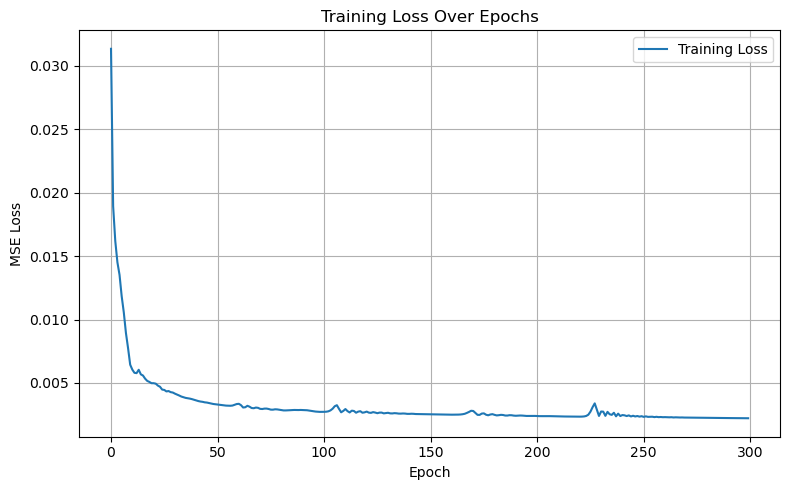

In [64]:
# Initialize model
model = GraphSAGEEdgePredictor(in_channels=5, hidden_channels=32)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
epochs = 300
losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, train_edge_pairs)
    loss = loss_fn(out, train_y)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Save loss

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plotting loss
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

try to plot the r2 value of the epochs.
There might be an embedded loss function in graphSAGE to find and plot separately. Similar nodes should have value similar to each other, balance with the opposite of far = different value?

**6. Evaluation parameters**

In [67]:
from sklearn.metrics import r2_score

# After model.eval() and predictions
model.eval()
with torch.no_grad():
    preds = model(data.x, data.edge_index, test_edge_pairs)
    test_loss = loss_fn(preds, test_y)
    r2 = r2_score(test_y.cpu().numpy(), preds.cpu().numpy())

    print(f"\nTest MSE: {test_loss.item():.4f}")
    print(f"Test R²: {r2:.4f}")



Test MSE: 0.0026
Test R²: 0.9092


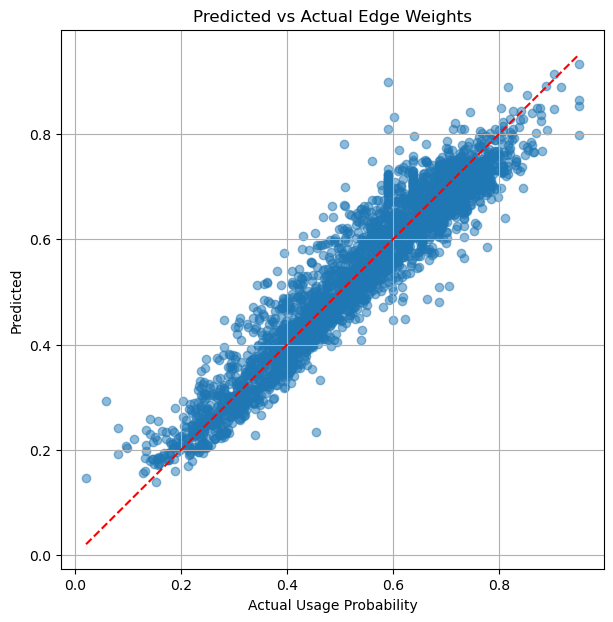

In [68]:
import matplotlib.pyplot as plt

# Ensure tensors are on CPU and converted to NumPy
actual = test_y.cpu().numpy()
predicted = preds.cpu().numpy()

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(actual, predicted, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # y = x line
plt.xlabel('Actual Usage Probability')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Edge Weights')
plt.grid(True)
plt.show()


**7. Visualize predicted values on road network**

In [69]:
# Create a copy to avoid modifying original df
df_with_preds = df.copy()

# Initialize predicted column with NaNs
df_with_preds['predicted_usageprobability'] = float('nan')

# Assign predictions to correct rows
df_with_preds.loc[test_idx, 'predicted_usageprobability'] = preds.cpu().numpy()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def compare_predictions(dataframe, true_col, pred_col, w, geometry_col='geometry', crs='EPSG:27700'):
    gs = gpd.GeoSeries.from_wkt(dataframe[geometry_col])
    gdf = gpd.GeoDataFrame(dataframe, geometry=gs, crs=crs)

    vmin = min(gdf[true_col].min(), gdf[pred_col].min())
    vmax = max(gdf[true_col].max(), gdf[pred_col].max())
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    gdf.plot(column=true_col, cmap='viridis', legend=True, ax=axes[0], norm=norm, linewidth = w)
    axes[0].set_title(f"True: {true_col}")
    axes[0].axis('off')

    gdf.plot(column=pred_col, cmap='viridis', legend=True, ax=axes[1], norm=norm, linewidth = w)
    axes[1].set_title(f"Predicted: {pred_col}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



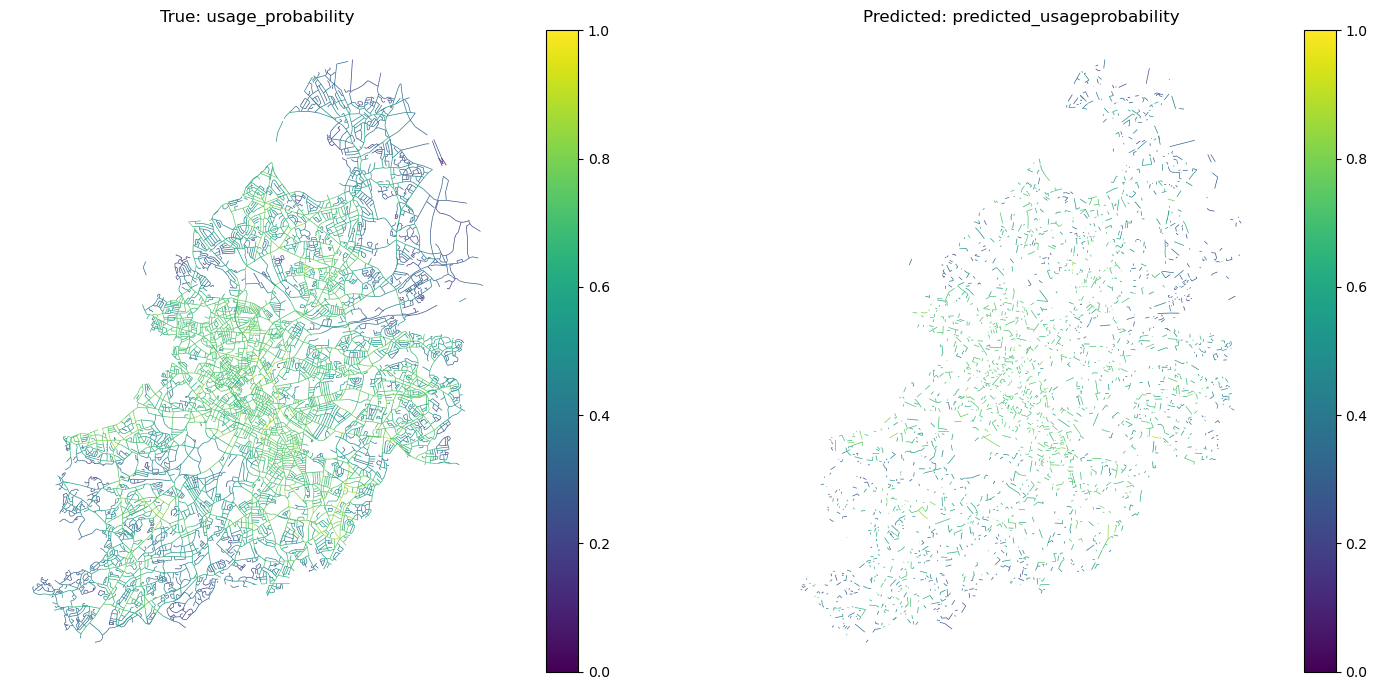

In [110]:
# just plot the test dataset first
compare_predictions(
    dataframe=df_with_preds,
    true_col='usage_probability',
    pred_col='predicted_usageprobability',
    w=0.5,  # Adjust line width as needed
    geometry_col='geometry'  # or 'wkt' if needed
)

In [72]:
# Define path where you want to save the file
output_path = "birmingham_with_predictions.csv"  # change path as needed

# Save to CSV
df_with_preds.to_csv(output_path, index=False)

print(f"Saved with predictions to: {output_path}")

Saved with predictions to: birmingham_with_predictions.csv


**8. Run & visualize predictions on the whole network**

In [76]:
model.eval()
with torch.no_grad():
    # Use all edges in the graph for prediction
    all_edge_pairs = df[['source_id', 'target_id']].values.T
    all_edge_pairs = torch.tensor(all_edge_pairs, dtype=torch.long)

    # Predict for all edges
    full_preds = model(data.x, data.edge_index, all_edge_pairs)


In [77]:
df_with_preds_full = df.copy()
df_with_preds_full['predicted_usageprobability'] = full_preds.cpu().numpy()

df_with_preds_full.to_csv("birmingham_full_predictions.csv", index=False)
print("Full network predictions saved to: birmingham_full_predictions.csv")


Full network predictions saved to: birmingham_full_predictions.csv


In [79]:
from sklearn.metrics import r2_score

# Ensure both actual and predicted values exist
actual = df_with_preds_full['usage_probability']
predicted = df_with_preds_full['predicted_usageprobability']

# Calculate R²
r2_cleaned = r2_score(actual, predicted)
print(f"R² for cleaned data: {r2_cleaned:.4f}")

R² for cleaned data: 0.9171


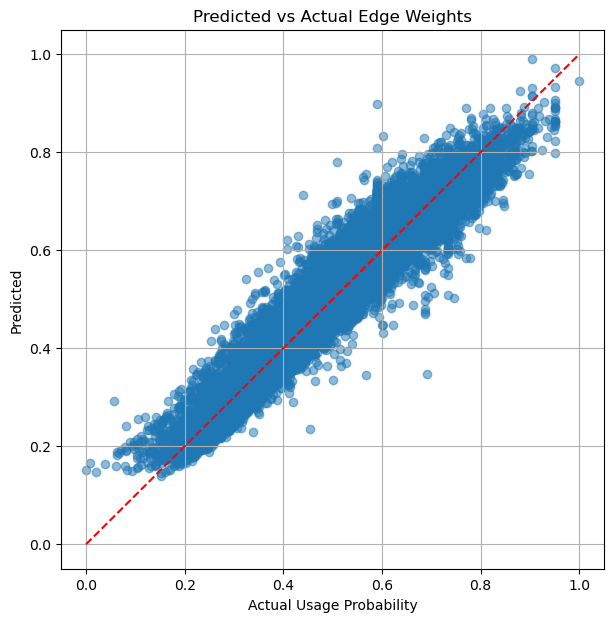

In [80]:
# Ensure tensors are on CPU and converted to NumPy
actual = np.array(df_with_preds_full['usage_probability'])
predicted = np.array(df_with_preds_full['predicted_usageprobability'])

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(actual, predicted, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # y = x line
plt.xlabel('Actual Usage Probability')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Edge Weights')
plt.grid(True)
plt.show()


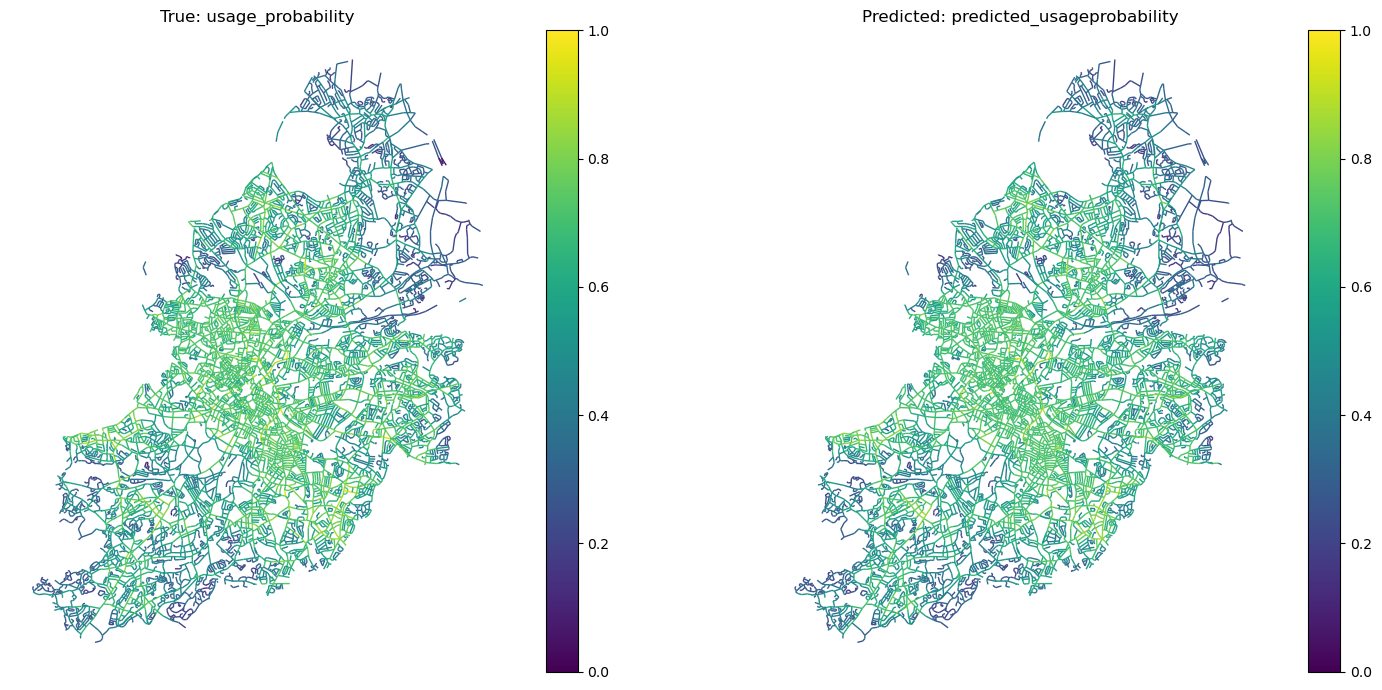

In [111]:
compare_predictions(
    dataframe=df_with_preds_full,
    true_col='usage_probability',
    pred_col='predicted_usageprobability',
    w=1,
    geometry_col='geometry'  # or 'wkt' if needed
)


Visualize Residuals

In [84]:
df_with_preds_full['residual'] = (
    df_with_preds_full['predicted_usageprobability'] - df_with_preds_full['usage_probability']
)

<Figure size 1200x800 with 0 Axes>

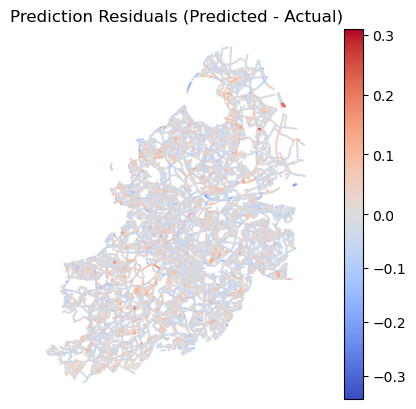

In [85]:
import geopandas as gpd
from matplotlib.colors import Normalize, TwoSlopeNorm

def plot_residuals(gdf, residual_col='residual', geometry_col='geometry', crs='EPSG:27700'):
    gs = gpd.GeoSeries.from_wkt(gdf[geometry_col]) if gdf[geometry_col].dtype == 'object' else gdf[geometry_col]
    gdf = gpd.GeoDataFrame(gdf, geometry=gs, crs=crs)

    # Use diverging color scale centered at 0
    vmin = gdf[residual_col].min()
    vmax = gdf[residual_col].max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    plt.figure(figsize=(12, 8))
    gdf.plot(column=residual_col, cmap='coolwarm', legend=True, norm=norm)
    plt.title("Prediction Residuals (Predicted - Actual)")
    plt.axis('off')
    plt.show()

# Call it
plot_residuals(df_with_preds_full)


**9. Testing trained model on London's network**

In [88]:
new_df = pd.read_csv("London_ALL.csv")  # Replace with your file path

def extract_coords(linestring):
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", linestring)
    coords = list(map(float, coords))
    return (coords[0], coords[1]), (coords[2], coords[3])

new_df['source_coords'], new_df['target_coords'] = zip(*new_df['wkt'].apply(extract_coords))

# Build unique node set
all_coords = pd.concat([new_df['source_coords'], new_df['target_coords']])
unique_coords = pd.Series(all_coords.unique())
coord_to_id = {coord: idx for idx, coord in enumerate(unique_coords)}

new_df['source_id'] = new_df['source_coords'].map(coord_to_id)
new_df['target_id'] = new_df['target_coords'].map(coord_to_id)


C:\Users\chalm\AppData\Local\Temp\ipykernel_15712\2578670153.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv("London_ALL.csv")  # Replace with your file path


In [100]:
num_nodes = len(coord_to_id)

# List of edge features to aggregate into nodes
edge_features = ['integration2km', 'nodecount2km', 'meridian_class_scale', 'trees_density', 'memorial_count']

# Initialize a dictionary to hold node-level aggregations
node_feature_dict_new = {feat: np.zeros(num_nodes) for feat in edge_features}

# Aggregate: sum edge features to connected nodes (both source and target)
for _, row in new_df.iterrows():
    src = row['source_id']
    tgt = row['target_id']
    for feat in edge_features:
        val = row[feat]
        node_feature_dict_new[feat][src] += val
        node_feature_dict_new[feat][tgt] += val

# Stack all features into a single tensor: shape [num_nodes, num_features]
node_feature_matrix_new = np.stack([node_feature_dict_new[feat] for feat in edge_features], axis=1)
x_new = torch.tensor(node_feature_matrix_new, dtype=torch.float)

scaler = StandardScaler()
x_new_np = scaler.fit_transform(x_new.numpy())

x_new = torch.tensor(x_new_np, dtype=torch.float)


print("Node feature tensor shape:", x_new.shape)  # Should be [num_nodes, 5]

Node feature tensor shape: torch.Size([86335, 5])


In [101]:
edge_index_new = torch.tensor(new_df[['source_id', 'target_id']].values.T, dtype=torch.long)

from torch_geometric.data import Data
data_new = Data(x=x_new, edge_index=edge_index_new)


In [102]:
model.eval()
with torch.no_grad():
    edge_pairs_new = edge_index_new  # all edges
    preds_new = model(data_new.x, data_new.edge_index, edge_pairs_new)


In [103]:
new_df['predicted_usageprobability'] = preds_new.cpu().numpy()
new_df.to_csv("new_network_predictions.csv", index=False)


In [104]:
from sklearn.metrics import r2_score

# Check both predicted and actual values exist
if 'integration2km' in new_df.columns:
    actual_new = new_df['usage_probability'].values
    predicted_new = new_df['predicted_usageprobability'].values

    r2_new = r2_score(actual_new, predicted_new)
    print(f"R² on new dataset: {r2_new:.4f}")
else:
    print("No ground truth 'usage_probability' found in new dataset.")


R² on new dataset: 0.8188


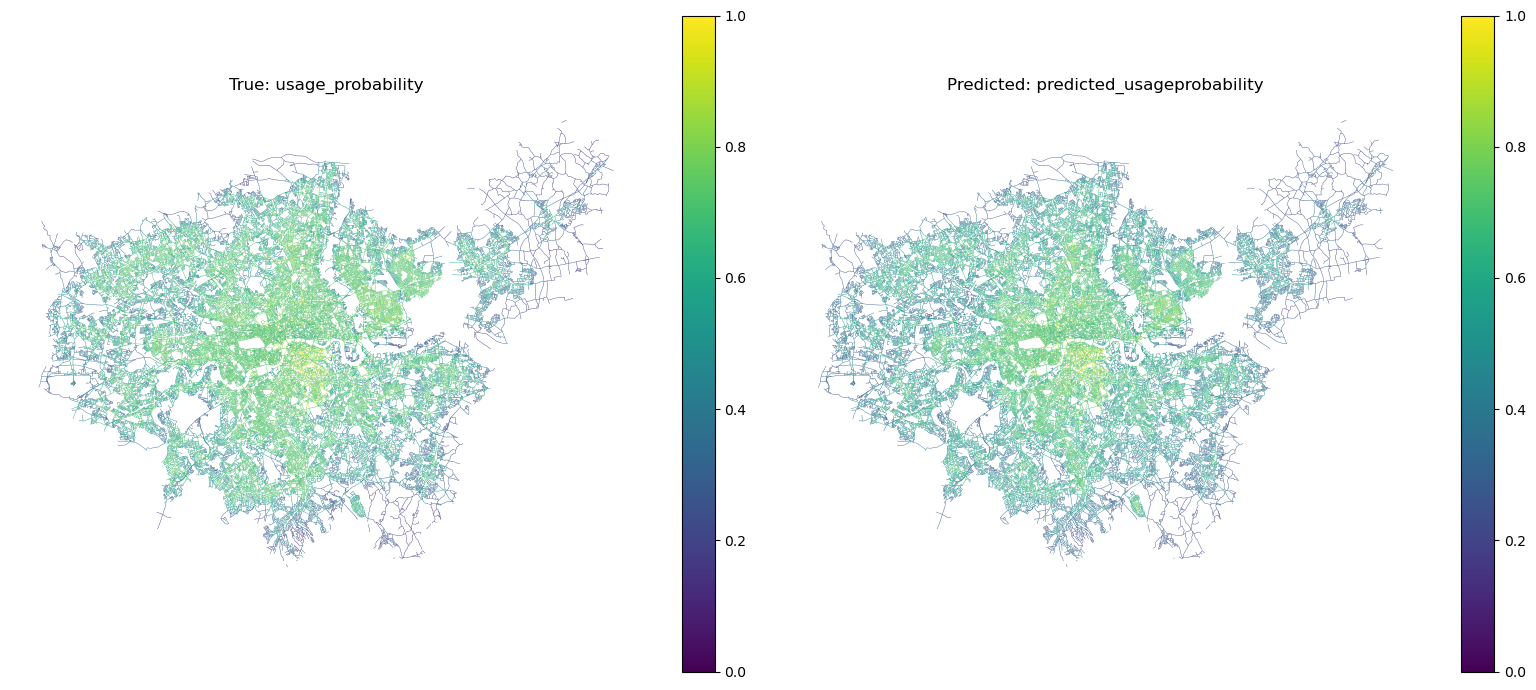

In [114]:
compare_predictions(
    dataframe=new_df,
    true_col='usage_probability',
    pred_col='predicted_usageprobability',
    w=0.3,
    geometry_col='wkt'  # 'geometry' or 'wkt' as needed
)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Ensure predictions and actual values exist
actual_london = new_df['integration2km'].values
predicted_london = new_df['predicted_integration'].values

mse_london = mean_squared_error(actual_london, predicted_london)
r2_london = r2_score(actual_london, predicted_london)

print(f"London MSE: {mse_london:.2f}")
print(f"London R²: {r2_london:.4f}")

London MSE: 0.00
London R²: 0.8188
